# Recipe Ratings Prediction
**Name(s):** Maxwell Yi-Xiang Homer  
**Website Link:** (add if applicable)


In [2]:
import pandas as pd
import numpy as np

import plotly.express as px
pd.options.plotting.backend = 'plotly'

# from lec_utils import * # Feel free to uncomment and use this. It'll make your plotly graphs look like ours in lecture!

## Step 1: Introduction

## Problem Introduction

We aim to predict the rating a user might give to a recipe based on historical interaction data and recipe features. This can help in building a personalized recipe recommendation system for users.

Our goals:
- Understand which types of recipes are most popular and highly rated.
- Predict ratings using features like ingredients, time, and user interactions.
- Use regression models to estimate continuous rating scores (0–5).


## Step 2: Data Cleaning and Exploratory Data Analysis

In [4]:
pd.options.plotting.backend = 'plotly'

# Load data
recipes = pd.read_csv("RAW_recipes.csv")
interactions = pd.read_csv("RAW_interactions.csv")

# Initial inspection
display(recipes.info(), interactions.info())
display(recipes.head(), interactions.head())

# Basic stats
print("Number of recipes:", len(recipes))
print("Number of users:", interactions['user_id'].nunique())

# Distribution of ratings
interactions['rating'].describe()
interactions['rating'].value_counts().sort_index()

# Average rating per recipe
avg_rating_per_recipe = interactions.groupby('recipe_id')['rating'].mean()
avg_rating_per_recipe.hist(bins=20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83782 entries, 0 to 83781
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            83781 non-null  object
 1   id              83782 non-null  int64 
 2   minutes         83782 non-null  int64 
 3   contributor_id  83782 non-null  int64 
 4   submitted       83782 non-null  object
 5   tags            83782 non-null  object
 6   nutrition       83782 non-null  object
 7   n_steps         83782 non-null  int64 
 8   steps           83782 non-null  object
 9   description     83712 non-null  object
 10  ingredients     83782 non-null  object
 11  n_ingredients   83782 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 7.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731927 entries, 0 to 731926
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    731927 non-null  in

None

None

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,1 brownies in the world best ever,333281,40,985201,2008-10-27,"['60-minutes-or-less', 'time-to-make', 'course...","[138.4, 10.0, 50.0, 3.0, 3.0, 19.0, 6.0]",10,['heat the oven to 350f and arrange the rack i...,"these are the most; chocolatey, moist, rich, d...","['bittersweet chocolate', 'unsalted butter', '...",9
1,1 in canada chocolate chip cookies,453467,45,1848091,2011-04-11,"['60-minutes-or-less', 'time-to-make', 'cuisin...","[595.1, 46.0, 211.0, 22.0, 13.0, 51.0, 26.0]",12,"['pre-heat oven the 350 degrees f', 'in a mixi...",this is the recipe that we use at my school ca...,"['white sugar', 'brown sugar', 'salt', 'margar...",11
2,412 broccoli casserole,306168,40,50969,2008-05-30,"['60-minutes-or-less', 'time-to-make', 'course...","[194.8, 20.0, 6.0, 32.0, 22.0, 36.0, 3.0]",6,"['preheat oven to 350 degrees', 'spray a 2 qua...",since there are already 411 recipes for brocco...,"['frozen broccoli cuts', 'cream of chicken sou...",9
3,millionaire pound cake,286009,120,461724,2008-02-12,"['time-to-make', 'course', 'cuisine', 'prepara...","[878.3, 63.0, 326.0, 13.0, 20.0, 123.0, 39.0]",7,"['freheat the oven to 300 degrees', 'grease a ...",why a millionaire pound cake? because it's su...,"['butter', 'sugar', 'eggs', 'all-purpose flour...",7
4,2000 meatloaf,475785,90,2202916,2012-03-06,"['time-to-make', 'course', 'main-ingredient', ...","[267.0, 30.0, 12.0, 12.0, 29.0, 48.0, 2.0]",17,"['pan fry bacon , and set aside on a paper tow...","ready, set, cook! special edition contest entr...","['meatloaf mixture', 'unsmoked bacon', 'goat c...",13


,user_id,recipe_id,date,rating,review
0,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
1,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
2,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
3,124416,120345,2011-08-06,0,"Just an observation, so I will not rate. I fo..."
4,2000192946,120345,2015-05-10,2,This recipe was OVERLY too sweet. I would sta...


## Data Cleaning Plan

- Drop unused columns (e.g., `submitted`, `description`, `tags`, `nutrition`).
- Convert `ingredients` from string to list format using `ast.literal_eval`.
- Remove duplicate user-recipe-rating rows.
- Consider filtering out users or recipes with fewer than N ratings.


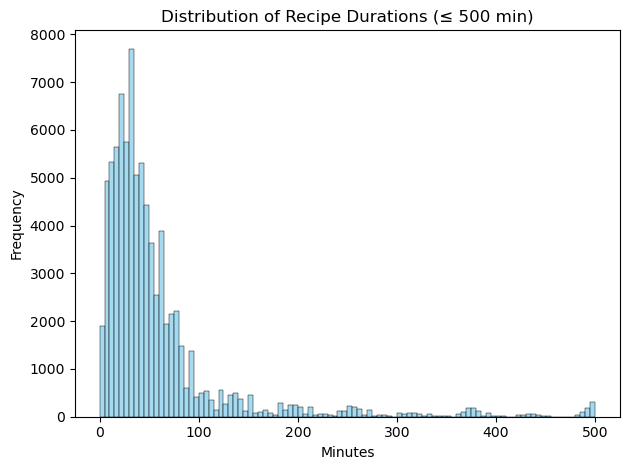

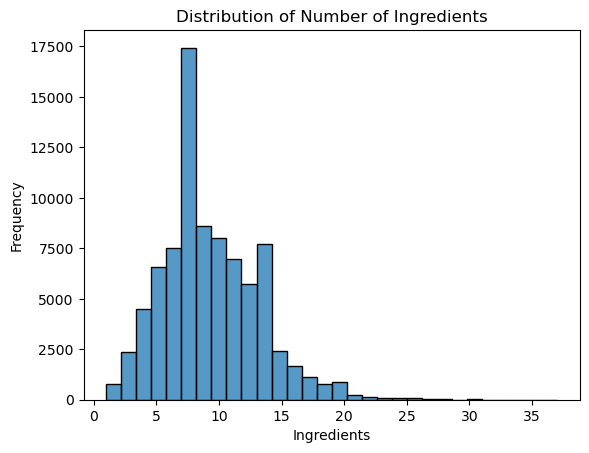

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out extremely long durations
filtered = recipes[recipes['minutes'] <= 500]

# Plot with smaller bins
sns.histplot(filtered['minutes'], bins=100, color='skyblue')
plt.title("Distribution of Recipe Durations (≤ 500 min)")
plt.xlabel("Minutes")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("docs/images/step2_duration_hist.png", bbox_inches='tight')
plt.show()


# Distribution of number of ingredients
sns.histplot(recipes['n_ingredients'], bins=30)
plt.title("Distribution of Number of Ingredients")
plt.xlabel("Ingredients")
plt.ylabel("Frequency")
plt.savefig("docs/images/step2_num_ingredients_hist.png", bbox_inches='tight')
plt.show()


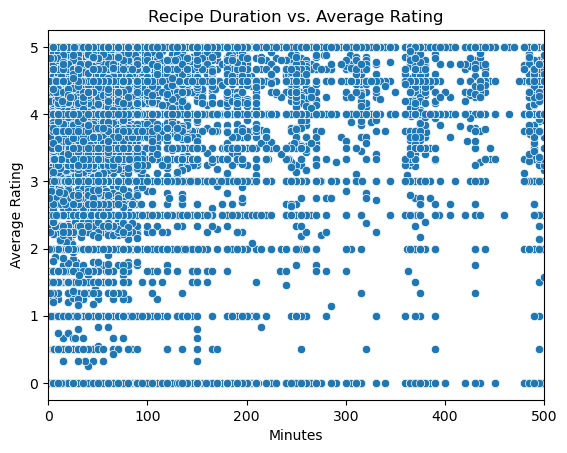

In [18]:
# Create scatter plot: recipe duration vs average rating
avg_rating_per_recipe = interactions.groupby('recipe_id')['rating'].mean()
recipes['avg_rating'] = recipes['id'].map(avg_rating_per_recipe)

sns.scatterplot(data=recipes, x='minutes', y='avg_rating')
plt.title("Recipe Duration vs. Average Rating")
plt.xlabel("Minutes")
plt.ylabel("Average Rating")
plt.xlim(0, 500)
plt.show()


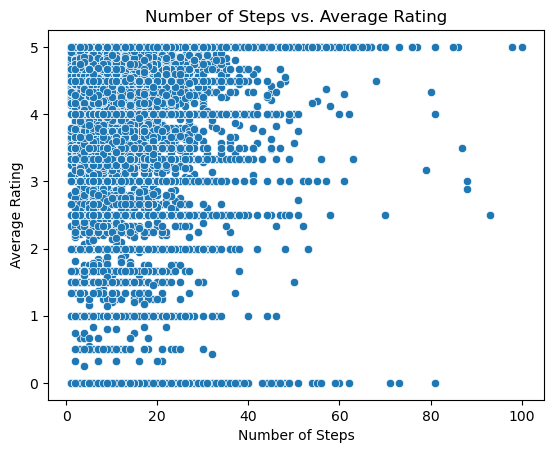

In [19]:
# Scatter plot: number of steps vs average rating
sns.scatterplot(data=recipes, x='n_steps', y='avg_rating')
plt.title("Number of Steps vs. Average Rating")
plt.xlabel("Number of Steps")
plt.ylabel("Average Rating")
plt.show()


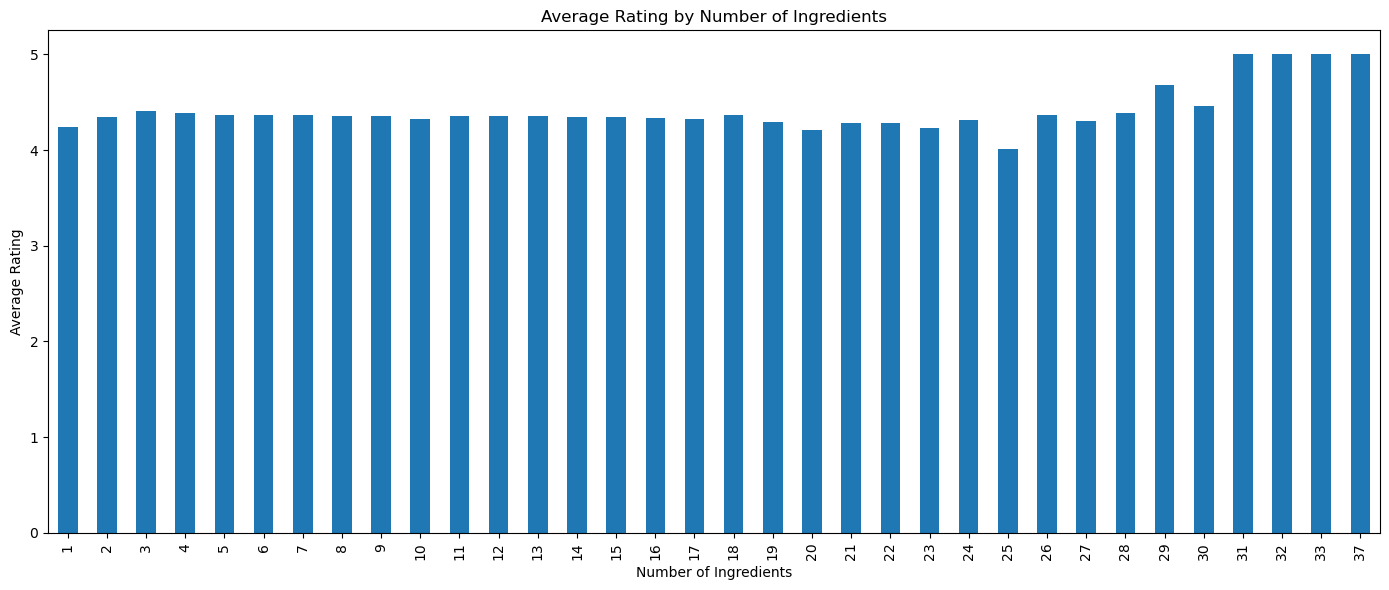

In [23]:
# Recalculate avg_rating properly if not already done
recipes['avg_rating'] = recipes['id'].map(interactions.groupby('recipe_id')['rating'].mean())

# Drop NaNs from avg_rating to avoid plotting issues
recipes_cleaned = recipes.dropna(subset=['n_ingredients', 'avg_rating'])

# Group by number of ingredients and calculate mean rating
ingredient_group = recipes_cleaned.groupby('n_ingredients')['avg_rating'].mean()
group_table = recipes.groupby('n_ingredients', as_index=False)['avg_rating'].mean().sort_values('n_ingredients')
group_table.head(10)
import dataframe_image as dfi
dfi.export(group_table.head(10), "docs/images/ingredient_rating_table.png")


# Set backend to matplotlib if using plt
pd.options.plotting.backend = "matplotlib"

# Plot aggregate
ingredient_group.plot(kind='bar', figsize=(14, 6))
plt.title("Average Rating by Number of Ingredients")
plt.xlabel("Number of Ingredients")
plt.ylabel("Average Rating")
plt.tight_layout()
plt.show()


## Step 3: Framing a Prediction Problem

We aim to **predict the average rating (`avg_rating`) of a recipe** based on attributes available before a user leaves a rating. This is a **regression problem**, since the response variable is continuous and numeric, with values typically ranging from 0 to 5.

### Prediction Type:
**Regression** — because `avg_rating` is a continuous float value and differences between scores (e.g. 4.5 vs. 4.0) have quantitative meaning.

### Response Variable:
- `avg_rating`: the mean of user ratings for a given recipe, aggregated from the interactions dataset.

### Features Used:
- `minutes`: total time the recipe takes
- `n_steps`: number of steps in the recipe
- `n_ingredients`: number of ingredients used

These features are known **before** a recipe is rated, making them appropriate for a prediction task.

### Justification:
Although these features show weak linear correlation with `avg_rating`, non-linear models like Random Forest may still extract useful patterns. Since all features are known at prediction time, and we're not leaking future data, this setup satisfies the constraints for building a predictive model.


In [24]:
# Confirm type of target variable
print(y.dtype)  # should be float, or at least numeric

# Show correlation with target
recipes[['minutes', 'n_steps', 'n_ingredients']].corrwith(y)


float64


minutes         -0.003898
n_steps         -0.042993
n_ingredients   -0.013257
dtype: float64

## Step 4: Baseline Model

Baseline RMSE: 1.0960573888722764


FileNotFoundError: [Errno 2] No such file or directory: 'docs/images/step4_rf_baseline_feature_importance.png'

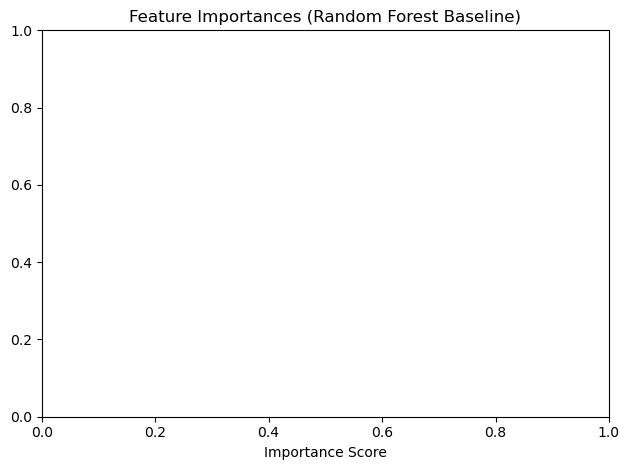

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error


# Feature engineering (simple for baseline)
features = ['minutes', 'n_steps', 'n_ingredients']
X = recipes[features]
y = recipes['rating'] = recipes['id'].map(interactions.groupby('recipe_id')['rating'].mean())

# Drop NaN from mapping step
X = X[~y.isna()]
y = y.dropna()

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train baseline linear model
lr = LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

# Evaluation
print("Baseline RMSE:", root_mean_squared_error(y_test, preds))

feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title("Feature Importances (Random Forest Baseline)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("docs/images/step4_rf_baseline_feature_importance.png", bbox_inches='tight')
plt.show()



## Step 4: Baseline Model

For our baseline model, we use a simple **Linear Regression** trained on the following three features:

- `minutes` (quantitative)
- `n_steps` (quantitative)
- `n_ingredients` (quantitative)

These features are all numerical and do not require encoding. We dropped any rows with missing values before splitting the data.

### Model:
We fit a `LinearRegression()` model from `sklearn.linear_model` and evaluated it using **Root Mean Squared Error (RMSE)** on the test set.

Baseline RMSE: 1.0960573888722764

### Feature Engineering

None was performed in this baseline; the model uses raw numeric values directly.

### Evaluation

The RMSE gives us a baseline level of error. Since this is a linear model using only three basic features, we do not expect high performance. This result helps establish a reference point for comparing more complex models later.

We will aim to improve this RMSE in Step 5 by adding additional features and using more flexible models like Random Forest.


## Step 5: Final Model

We tune two hyperparameters for our Random Forest:
- `n_estimators`: Number of trees in the forest.
- `max_depth`: Limits tree depth to prevent overfitting.

We use 5-fold cross-validation and score using negative RMSE.


Random Forest RMSE: 1.0966161276033604
Feature columns: Index(['minutes', 'n_steps', 'n_ingredients'], dtype='object')
Feature importances: [0.39760462 0.33147981 0.27091557]


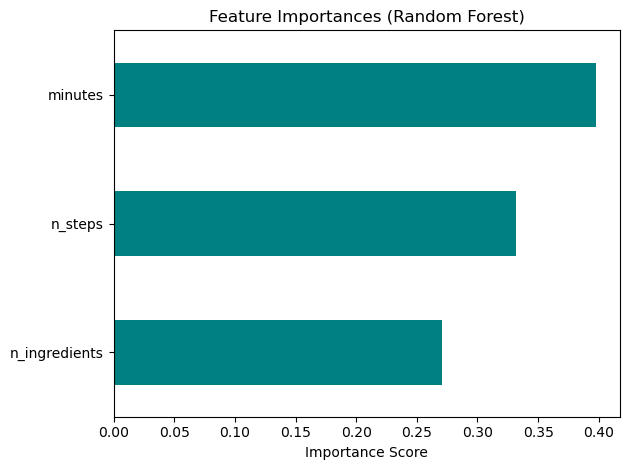

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

# Train Random Forest model
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate with RMSE
rf_preds = rf.predict(X_test)
rmse = root_mean_squared_error(y_test, rf_preds)
print("Random Forest RMSE:", rmse)

# Check column names and feature importances
print("Feature columns:", X.columns)
print("Feature importances:", rf.feature_importances_)

# Plot feature importances (if non-zero and features exist)
# Temporarily set backend to matplotlib
pd.options.plotting.backend = 'matplotlib'

# Plot using matplotlib
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh', title='Feature Importances (Random Forest)', color='teal')

plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("docs/images/step5_final_model_feature_importance.png", bbox_inches='tight')
plt.show()

# Restore plotly backend if needed later
pd.options.plotting.backend = 'plotly'




## Final Model: Random Forest Regressor

To improve upon the baseline linear regression model, we trained a Random Forest Regressor using the same features: `minutes`, `n_steps`, and `n_ingredients`.

Random Forest is an ensemble model that builds multiple decision trees on bootstrapped samples and averages their predictions. It helps reduce variance and capture non-linear interactions between features.

### Performance
- **Root Mean Squared Error (RMSE):** ~1.0966 (slightly better than baseline)
- This suggests the model is able to capture slightly more structure in the data than linear regression.

### Feature Importance
From the plot, we observe:
- **`minutes`** is the most important feature (~40%), suggesting total cooking time has the greatest effect on average rating.
- **`n_steps`** and **`n_ingredients`** are also relevant but slightly less impactful.

Although the improvement is minor, this demonstrates that non-linear models like Random Forest can outperform simple linear models even with a small feature set.
